# NucSegAI Result Analysis - Cell Type Quantification

This notebook analyzes NucSegAI JSON output files to extract:
- Cell counts by type
- Cell type proportions
- Cell density by type (cells/tile and cells/mm²)
- Type probability statistics

This notebook provides:
1. ✅ Single JSON file analysis
2. ✅ Cell type counts and proportions
3. ✅ Cell density calculation (cells/tile and cells/mm²) by type
4. ✅ Type probability statistics (min, median, mean, max, standard deviation)
5. ✅ Visualizations (bar charts, pie charts)
6. ✅ CSV export functionality (including density by type)
7. ✅ Batch processing for all json files
8. ✅ Automatic density CSV export (cells/tile and cells/mm² by cell type)

---

## Step 1: Import Required Libraries

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 2: Define Cell Type Dictionary

This mapping translates numeric cell type IDs to human-readable names.

In [2]:
# Cell type mapping
CELL_TYPE_DICT = {
    0: "Undefined",
    1: "Epithelium (PD-L1lo/Ki67lo)",
    2: "Epithelium (PD-L1hi/Ki67hi)",
    3: "Macrophage",
    4: "Lymphocyte",
    5: "Vascular",
    6: "Fibroblast/Stroma"
}

# Color mapping for visualization (converted from RGB to hex)
CELL_TYPE_COLORS = {
    0: "#000000",  # Black (RGB: 0, 0, 0) - Undefined
    1: "#387F39",  # Dark Green (RGB: 56, 127, 57) - Epithelium low
    2: "#00FF00",  # Bright Green (RGB: 0, 255, 0) - Epithelium high
    3: "#FC8D62",  # Coral/Salmon (RGB: 252, 141, 98) - Macrophage
    4: "#FFD92F",  # Yellow (RGB: 255, 217, 47) - Lymphocyte
    5: "#4535C1",  # Blue/Purple (RGB: 69, 53, 193) - Vascular
    6: "#17BECF"   # Cyan (RGB: 23, 190, 207) - Fibroblast/Stroma
}

# Tile physical size configuration
# Set the physical size of each tile in mm^2
# Example: For 4x4 mm^2 tiles, set TILE_AREA_MM2 = 16.0
TILE_AREA_MM2 = 4.0  # Tile area in square millimeters (mm^2)

print("Cell Type Mapping:")
for type_id, type_name in CELL_TYPE_DICT.items():
    print(f"  {type_id}: {type_name} -> {CELL_TYPE_COLORS[type_id]}")
print(f"\nTile Area Configuration: {TILE_AREA_MM2} mm^2 per tile")

Cell Type Mapping:
  0: Undefined -> #000000
  1: Epithelium (PD-L1lo/Ki67lo) -> #387F39
  2: Epithelium (PD-L1hi/Ki67hi) -> #00FF00
  3: Macrophage -> #FC8D62
  4: Lymphocyte -> #FFD92F
  5: Vascular -> #4535C1
  6: Fibroblast/Stroma -> #17BECF

Tile Area Configuration: 4.0 mm^2 per tile


## Step 3: Define Function to Analyze Single JSON File

This function reads a single JSON file and extracts all relevant statistics.

In [3]:
def analyze_single_json(json_path, tile_area_mm2=TILE_AREA_MM2):
    """
    Analyze a single NucSegAI JSON output file
    
    Args:
        json_path (str or Path): Path to JSON file
        tile_area_mm2 (float): Area of each tile in square millimeters, defaults to global configuration
    
    Returns:
        dict: Dictionary containing analysis results, including cell counts, proportions, type probability statistics, and density information
    """
    # Read JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Extract nucleus data
    nuclei = data.get('nuc', {})
    
    if not nuclei:
        return {
            'filename': Path(json_path).name,
            'total_cells': 0,
            'num_tiles': 1,
            'tile_area_mm2': tile_area_mm2,
            'cell_counts': {},
            'cell_proportions': {},
            'cell_density_per_tile': {},
            'cell_density_per_mm2': {},
            'type_prob_stats_overall': {},
            'type_prob_stats_by_type': {}
        }
    
    # Initialize storage
    cell_types = []
    type_probs = []
    type_probs_by_type = defaultdict(list)
    
    # Extract data from each nucleus
    for nucleus_id, nucleus_data in nuclei.items():
        cell_type = nucleus_data.get('type', 0)
        type_prob = nucleus_data.get('type_prob', 0)
        
        cell_types.append(cell_type)
        type_probs.append(type_prob)
        type_probs_by_type[cell_type].append(type_prob)
    
    # Count cells by type
    cell_counts = Counter(cell_types)
    total_cells = len(cell_types)
    num_tiles = 1  # Single file corresponds to one tile
    
    # Calculate proportions
    cell_proportions = {}
    for cell_type, count in cell_counts.items():
        cell_proportions[cell_type] = count / total_cells if total_cells > 0 else 0
    
    # Calculate cell density per type (cells/tile)
    cell_density_per_tile = {}
    for cell_type, count in cell_counts.items():
        cell_density_per_tile[cell_type] = count / num_tiles
    
    # Calculate cell density per type (cells/mm^2)
    cell_density_per_mm2 = {}
    for cell_type, count in cell_counts.items():
        cell_density_per_mm2[cell_type] = count / tile_area_mm2 if tile_area_mm2 > 0 else 0
    
    # Calculate type probability statistics (overall)
    type_prob_stats_overall = {
        'min': np.min(type_probs) if type_probs else 0,
        'median': np.median(type_probs) if type_probs else 0,
        'mean': np.mean(type_probs) if type_probs else 0,
        'max': np.max(type_probs) if type_probs else 0,
        'std': np.std(type_probs) if type_probs else 0
    }
    
    # Calculate type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, probs in type_probs_by_type.items():
        type_prob_stats_by_type[cell_type] = {
            'min': np.min(probs),
            'median': np.median(probs),
            'mean': np.mean(probs),
            'max': np.max(probs),
            'std': np.std(probs)
        }
    
    return {
        'filename': Path(json_path).name,
        'total_cells': total_cells,
        'num_tiles': num_tiles,
        'tile_area_mm2': tile_area_mm2,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'cell_density_per_tile': cell_density_per_tile,
        'cell_density_per_mm2': cell_density_per_mm2,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type
    }

print("✅ Function defined: analyze_single_json()")

✅ Function defined: analyze_single_json()


## Step 4: Display Results Function

Create a function to display results in a readable format.

In [4]:
def display_results(results):
    """
    Display analysis results in a formatted way.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    print("="*80)
    print(f"Analysis Results for: {results['filename']}")
    print("="*80)
    print(f"\n📊 Total Cells Detected: {results['total_cells']:,}")
    if 'num_tiles' in results:
        print(f"📊 Number of Tiles: {results['num_tiles']:,}")
    if 'tile_area_mm2' in results:
        print(f"📊 Tile Area: {results['tile_area_mm2']} mm²")
    print()
    
    # Cell Counts, Proportions, and Density
    print("─" * 80)
    print("Cell Type Distribution with Density")
    print("─" * 80)
    print(f"{'Cell Type':<35} {'Count':>12} {'Proportion':>12} {'Percentage':>10} {'Cells/Tile':>12} {'Cells/mm²':>12}")
    print("─" * 80)
    
    for cell_type in sorted(results['cell_counts'].keys()):
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]
        percentage = proportion * 100
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        
        # Get density information
        density_per_tile = results.get('cell_density_per_tile', {}).get(cell_type, 0)
        density_per_mm2 = results.get('cell_density_per_mm2', {}).get(cell_type, 0)
        
        print(f"{type_name:<35} {count:>12,} {proportion:>12.4f} {percentage:>9.2f}% {density_per_tile:>12.2f} {density_per_mm2:>12.2f}")
    
    # Overall Type Probability Statistics
    print("\n" + "─" * 80)
    print("Overall Type Probability Statistics")
    print("─" * 80)
    stats = results['type_prob_stats_overall']
    print(f"  Minimum:  {stats['min']:.10f}")
    print(f"  Median:   {stats['median']:.10f}")
    print(f"  Mean:     {stats['mean']:.10f}")
    print(f"  Maximum:  {stats['max']:.10f}")
    print(f"  Std Dev:  {stats['std']:.10f}")
    
    # Type Probability Statistics by Cell Type
    print("\n" + "─" * 80)
    print("Type Probability Statistics by Cell Type")
    print("─" * 80)
    
    for cell_type in sorted(results['type_prob_stats_by_type'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        stats = results['type_prob_stats_by_type'][cell_type]
        print(f"\n{type_name}:")
        print(f"  Min: {stats['min']:.6f} | Med: {stats['median']:.6f} | Mean: {stats['mean']:.6f} | Max: {stats['max']:.6f} | Std: {stats['std']:.6f}")
    
    print("\n" + "="*80)

print("✅ Function defined: display_results()")

✅ Function defined: display_results()


## Step 5: Analyze Single JSON File

**👉 Update the path below to point to your JSON file**

In [5]:
def plot_cell_type_distribution(results):
    """
    Create visualizations for cell type distribution.

    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Prepare data
    cell_types = sorted(results['cell_counts'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    counts = [results['cell_counts'][ct] for ct in cell_types]
    colors = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]

    # Bar plot
    bars = axes[0].bar(range(len(cell_types)), counts, color=colors, edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Cell Counts by Type\n{results["filename"]}', fontsize=14, fontweight='bold')
    axes[0].set_xticks(range(len(cell_types)))

    # Right-align labels with bars - labels end at bar center
    axes[0].set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    axes[0].grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(counts):
        axes[0].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # Pie chart with autopct for percentages only on larger slices
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 3 else ''  # Only show percentage if > 3%

    # Create pie chart with legend instead of labels for small slices
    wedges, texts, autotexts = axes[1].pie(
        counts,
        labels=None,  # Don't add labels directly to avoid overlap
        colors=colors,
        autopct=autopct_format,
        startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold', 'color': 'black'},
        pctdistance=0.85
    )

    # Style pie labels: black text with bright outline for readability
    import matplotlib.patheffects as patheffects
    for t in autotexts:
        t.set_color('black')
        t.set_path_effects([patheffects.withStroke(linewidth=2.5, foreground='white')])

    # Create legend with labels and percentages
    legend_labels = [f'{name}: {count:,} ({count/sum(counts)*100:.1f}%)'
                     for name, count in zip(cell_names, counts)]
    axes[1].legend(
        wedges,
        legend_labels,
        title="Cell Types",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=9
    )

    axes[1].set_title(f'Cell Type Proportions\n{results["filename"]}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_type_probability_distribution(results):
    """
    Create bar plot for type probabilities by cell type.

    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    cell_types = sorted(results['type_prob_stats_by_type'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]

    # Create bar plot for mean values with error bars
    means = [results['type_prob_stats_by_type'][ct]['mean'] for ct in cell_types]
    stds = [results['type_prob_stats_by_type'][ct]['std'] for ct in cell_types]
    colors_list = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]

    bars = ax.bar(range(len(cell_types)), means, yerr=stds, color=colors_list,
                   edgecolor='black', linewidth=1.5, capsize=5, alpha=0.8)

    ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Type Probability', fontsize=12, fontweight='bold')
    ax.set_title(f'Type Probability by Cell Type (Mean ± Std Dev)\n{results["filename"]}',
                 fontsize=14, fontweight='bold', pad=30)
    ax.set_xticks(range(len(cell_types)))

    # Right-align labels with bars - labels end at bar center
    ax.set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', va='bottom',
                fontweight='bold', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("✅ Visualization functions defined")

✅ Visualization functions defined


In [6]:
# ⚠️ UPDATE THIS PATH TO YOUR JSON FILE
json_file_path = "/mnt/j/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred/json/tile_39520_7904.json"  # Change this to your file path

# Check if file exists
if not Path(json_file_path).exists():
    print(f"❌ Error: File not found at {json_file_path}")
    print("Please update the json_file_path variable with the correct path.")
else:
    print(f"✅ File found: {json_file_path}")
    
    # Analyze the file
    results = analyze_single_json(json_file_path)
    
    # Display results
    # display_results(results)
    
    # Create visualizations
    # print("\n📊 Generating visualizations...\n")
    # plot_cell_type_distribution(results)
    # plot_type_probability_distribution(results)

✅ File found: /mnt/j/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred/json/tile_39520_7904.json


## Step 6: Apply Confidence Threshold Filter

In [7]:
"""
## Step 6: Apply Confidence Threshold Filter

Filter out low-confidence predictions and reclassify them as "Undefined".
"""

def apply_confidence_filter(json_path, threshold=0.5, tile_area_mm2=TILE_AREA_MM2):
    """
    Apply confidence threshold filter to reclassify low-confidence predictions
    
    Args:
        json_path (str or Path): Path to JSON file
        threshold (float): Minimum type probability threshold (default: 0.5)
        tile_area_mm2 (float): Area of each tile in square millimeters, defaults to global configuration
    
    Returns:
        dict: Filtered analysis results, including cell counts, proportions, density, and type probability statistics
    """
    # Read JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract nucleus data
    nuclei = data.get('nuc', {})

    if not nuclei:
        return {
            'filename': Path(json_path).name,
            'threshold': threshold,
            'total_cells': 0,
            'num_tiles': 1,
            'tile_area_mm2': tile_area_mm2,
            'reclassified_count': 0,
            'cell_counts': {},
            'cell_proportions': {},
            'cell_density_per_tile': {},
            'cell_density_per_mm2': {},
            'type_prob_stats_overall': {},
            'type_prob_stats_by_type': {},
            'original_cell_counts': {}
        }

    # Initialize storage
    original_types = []
    filtered_types = []
    type_probs = []
    type_probs_by_type = defaultdict(list)
    reclassified_count = 0

    # Apply filter and extract data
    for nucleus_id, nucleus_data in nuclei.items():
        original_type = nucleus_data.get('type', 0)
        type_prob = nucleus_data.get('type_prob', 0)

        original_types.append(original_type)

        # Apply filter: if below threshold, reclassify as Undefined (0)
        if type_prob < threshold and original_type != 0:
            filtered_type = 0  # Reclassify as Undefined
            reclassified_count += 1
        else:
            filtered_type = original_type

        filtered_types.append(filtered_type)
        type_probs.append(type_prob)
        type_probs_by_type[filtered_type].append(type_prob)

    # Count cells by filtered type
    cell_counts = Counter(filtered_types)
    total_cells = len(filtered_types)
    num_tiles = 1  # Single file corresponds to one tile

    # Calculate proportions
    cell_proportions = {}
    for cell_type, count in cell_counts.items():
        cell_proportions[cell_type] = count / total_cells if total_cells > 0 else 0

    # Calculate cell density per type (cells/tile)
    cell_density_per_tile = {}
    for cell_type, count in cell_counts.items():
        cell_density_per_tile[cell_type] = count / num_tiles

    # Calculate cell density per type (cells/mm^2)
    cell_density_per_mm2 = {}
    for cell_type, count in cell_counts.items():
        cell_density_per_mm2[cell_type] = count / tile_area_mm2 if tile_area_mm2 > 0 else 0

    # Calculate type probability statistics (overall)
    type_prob_stats_overall = {
        'min': np.min(type_probs) if type_probs else 0,
        'median': np.median(type_probs) if type_probs else 0,
        'mean': np.mean(type_probs) if type_probs else 0,
        'max': np.max(type_probs) if type_probs else 0,
        'std': np.std(type_probs) if type_probs else 0
    }

    # Calculate type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, probs in type_probs_by_type.items():
        type_prob_stats_by_type[cell_type] = {
            'min': np.min(probs),
            'median': np.median(probs),
            'mean': np.mean(probs),
            'max': np.max(probs),
            'std': np.std(probs)
        }

    tile_name = Path(json_path).stem
    return {
        'filename': f"{tile_name}_threshold_{int(threshold*100)}.json",
        'threshold': threshold,
        'total_cells': total_cells,
        'num_tiles': num_tiles,
        'tile_area_mm2': tile_area_mm2,
        'reclassified_count': reclassified_count,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'cell_density_per_tile': cell_density_per_tile,
        'cell_density_per_mm2': cell_density_per_mm2,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type,
        'original_cell_counts': dict(Counter(original_types))
    }

print("✅ Filtering functions defined")

✅ Filtering functions defined


### Display the results:

Applying confidence threshold filter: 0.5


📊 Generating comparison visualizations...

Analysis Results for: tile_39520_7904_threshold_50.json

📊 Total Cells Detected: 2,503
📊 Number of Tiles: 1
📊 Tile Area: 4.0 mm²

────────────────────────────────────────────────────────────────────────────────
Cell Type Distribution with Density
────────────────────────────────────────────────────────────────────────────────
Cell Type                                  Count   Proportion Percentage   Cells/Tile    Cells/mm²
────────────────────────────────────────────────────────────────────────────────
Undefined                                    174       0.0695      6.95%       174.00        43.50
Epithelium (PD-L1lo/Ki67lo)                  167       0.0667      6.67%       167.00        41.75
Epithelium (PD-L1hi/Ki67hi)                  196       0.0783      7.83%       196.00        49.00
Macrophage                                   209       0.0835      8.35%       209.00        52.25
Lymphocyt

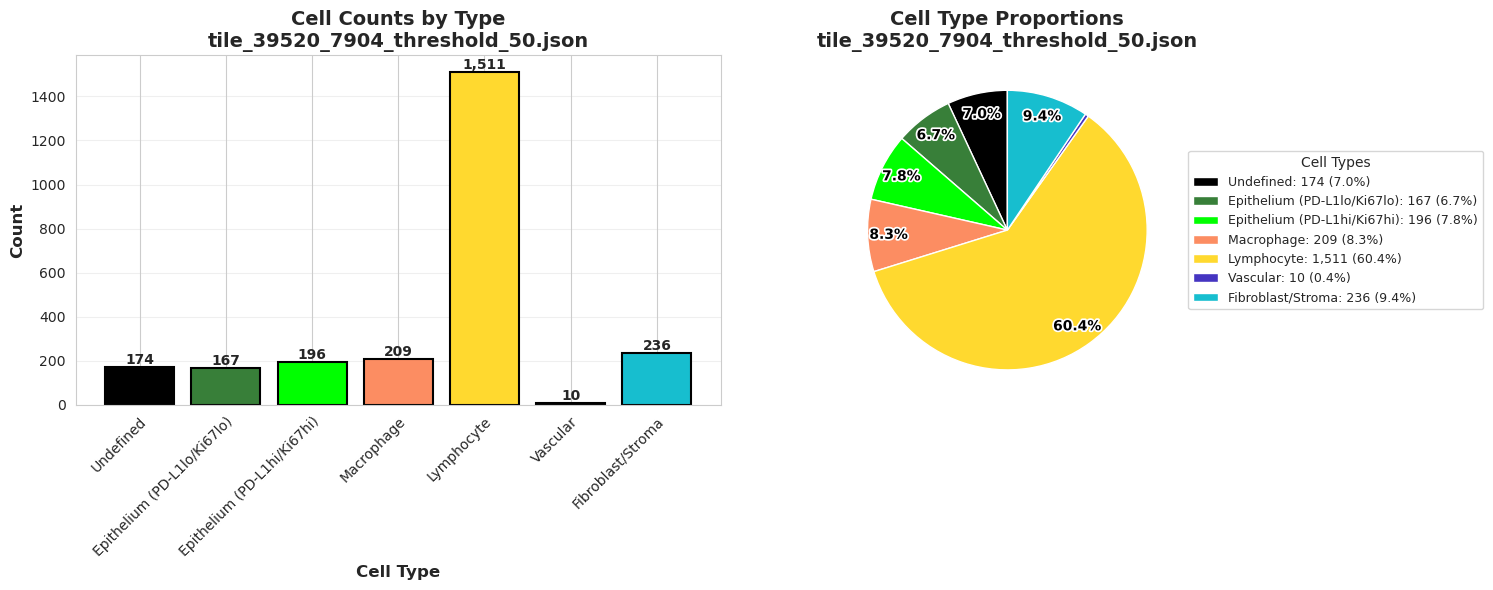

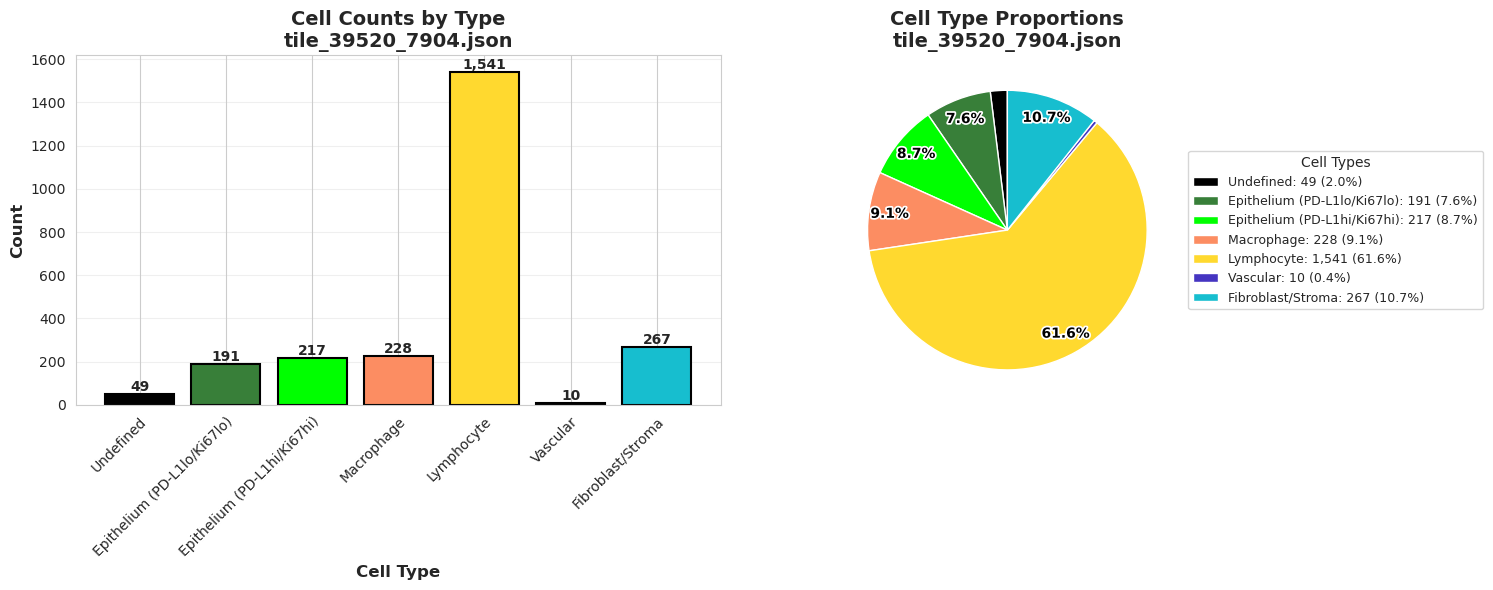

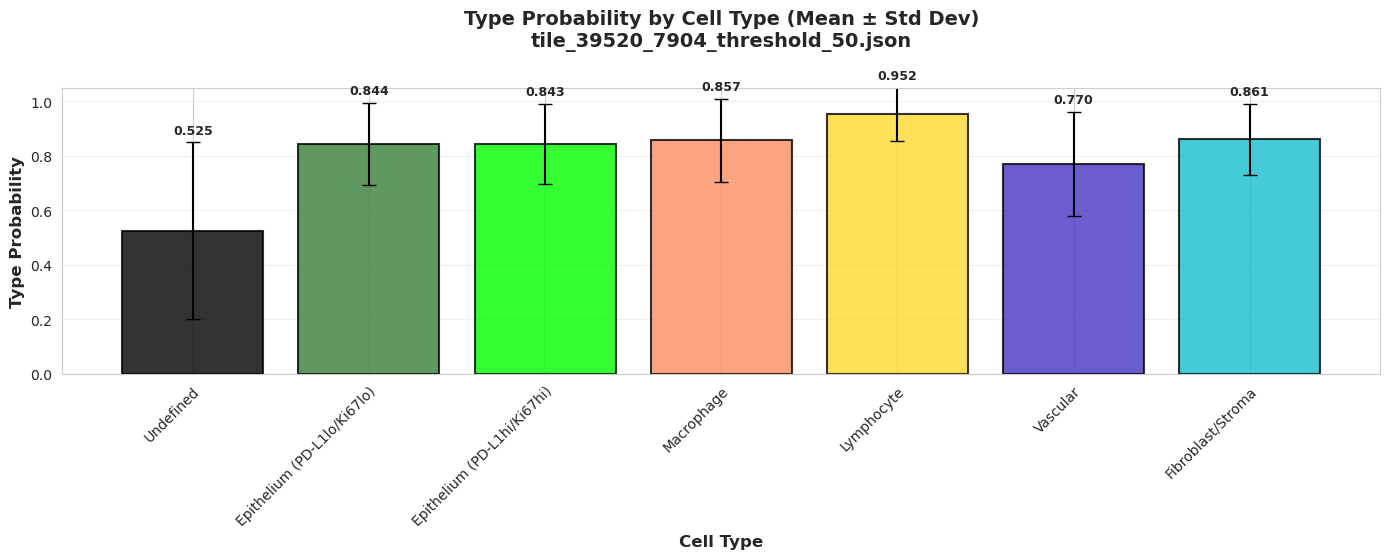

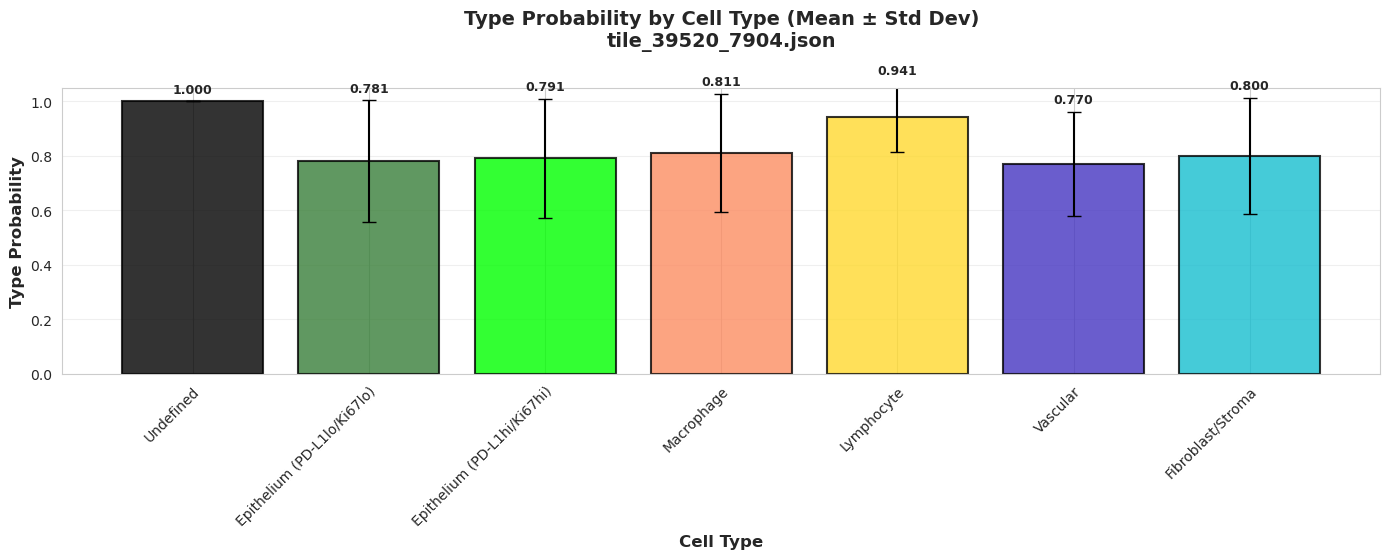

In [8]:
# ⚠️ Set your threshold here (default: 0.5)
CONFIDENCE_THRESHOLD = 0.5

if 'results' in locals():
    print(f"Applying confidence threshold filter: {CONFIDENCE_THRESHOLD}\n")

    # Apply filter
    filtered_results = apply_confidence_filter(json_file_path, threshold=CONFIDENCE_THRESHOLD)

    print("\n📊 Generating comparison visualizations...\n")

    display_results(filtered_results)
    display_results(results)
    # Display filtered results
    plot_cell_type_distribution(filtered_results)
    plot_cell_type_distribution(results)

    # Create comparison visualizations
    plot_type_probability_distribution(filtered_results)
    plot_type_probability_distribution(results)

else:
    print("⚠️ No results to filter. Please run Step 5 first.")

## Step 7: Export Results to CSV/Excel

In [9]:
"""
## Step 7: Export Results to CSV/Excel

Export both original (unfiltered) and filtered results to separate CSV files.
"""

def export_results_to_csv(results, output_path="cell_analysis_results.csv", is_filtered=False):
    """
    Export analysis results to CSV file
    
    Args:
        results (dict): Results dictionary from analyze_single_json() or apply_confidence_filter()
        output_path (str): Output CSV file path
        is_filtered (bool): Whether results are filtered (adds threshold information)
    
    Returns:
        pd.DataFrame: DataFrame containing exported data
    """
    # Prepare DataFrame data
    data_rows = []

    for cell_type in sorted(results['cell_counts'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}")
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]

        stats = results['type_prob_stats_by_type'][cell_type]

        # Get density information
        density_per_tile = results.get('cell_density_per_tile', {}).get(cell_type, 0)
        density_per_mm2 = results.get('cell_density_per_mm2', {}).get(cell_type, 0)

        row_data = {
            'Filename': results['filename'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': type_name,
            'Count': count,
            'Proportion': proportion,
            'Percentage': proportion * 100,
            'Cells_Per_Tile': density_per_tile,
            'Cells_Per_mm2': density_per_mm2,
            'TypeProb_Min': stats['min'],
            'TypeProb_Median': stats['median'],
            'TypeProb_Mean': stats['mean'],
            'TypeProb_Max': stats['max'],
            'TypeProb_Std': stats['std']
        }

        # Add filter-related columns (only when original_cell_counts exists)
        if is_filtered and 'original_cell_counts' in results:
            row_data['Original_Count'] = results['original_cell_counts'].get(cell_type, 0)
            row_data['Count_Change'] = count - results['original_cell_counts'].get(cell_type, 0)
            row_data['Threshold'] = results.get('threshold', 'N/A')

        data_rows.append(row_data)

    # Create DataFrame
    df = pd.DataFrame(data_rows)

    # Reorder columns for filtered results (Threshold at the end)
    if is_filtered and 'original_cell_counts' in results:
        column_order = ['Filename', 'Cell_Type_ID', 'Cell_Type_Name',
                       'Original_Count', 'Count', 'Count_Change', 'Proportion', 'Percentage',
                       'Cells_Per_Tile', 'Cells_Per_mm2',
                       'TypeProb_Min', 'TypeProb_Median', 'TypeProb_Mean', 'TypeProb_Max',
                       'TypeProb_Std', 'Threshold']
        df = df[column_order]
    else:
        # Column order for unfiltered results
        column_order = ['Filename', 'Cell_Type_ID', 'Cell_Type_Name',
                       'Count', 'Proportion', 'Percentage',
                       'Cells_Per_Tile', 'Cells_Per_mm2',
                       'TypeProb_Min', 'TypeProb_Median', 'TypeProb_Mean', 'TypeProb_Max',
                       'TypeProb_Std']
        df = df[column_order]

    # Export to CSV
    df.to_csv(output_path, index=False)
    print(f"✅ Results exported to: {output_path}")

    return df

def export_density_summary_to_csv(results, output_path="cell_density_summary.csv", is_filtered=False):
    """
    Export cell density metrics (cells/tile and cells/mm^2) by cell type to CSV.
    
    Args:
        results (dict): Results dictionary from analyze_single_json() or aggregate_results()
        output_path (str): Output CSV file path
        is_filtered (bool): Whether results are filtered (adds threshold info)
    
    Returns:
        pd.DataFrame: DataFrame containing density data
    """
    # Prepare DataFrame data
    data_rows = []
    
    for cell_type in sorted(results['cell_counts'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}")
        count = results['cell_counts'][cell_type]
        
        # Get density information
        density_per_tile = results.get('cell_density_per_tile', {}).get(cell_type, 0)
        density_per_mm2 = results.get('cell_density_per_mm2', {}).get(cell_type, 0)
        
        row_data = {
            'Filename': results['filename'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': type_name,
            'Count': count,
            'Cells_Per_Tile': density_per_tile,
            'Cells_Per_mm2': density_per_mm2
        }
        
        # Add tile area info
        row_data['Tile_Area_mm2'] = results.get('tile_area_mm2', TILE_AREA_MM2)
        
        # Add number of tiles if available
        if 'num_tiles' in results:
            row_data['Num_Tiles'] = results['num_tiles']
        
        # Add threshold info for filtered results
        if is_filtered and 'threshold' in results:
            row_data['Threshold'] = results.get('threshold', 'N/A')
        
        data_rows.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Set column order
    base_columns = ['Filename', 'Cell_Type_ID', 'Cell_Type_Name', 'Count', 
                   'Cells_Per_Tile', 'Cells_Per_mm2', 'Tile_Area_mm2']
    
    if 'num_tiles' in results:
        base_columns.insert(-1, 'Num_Tiles')
    
    if is_filtered and 'threshold' in results:
        base_columns.append('Threshold')
    
    df = df[base_columns]
    
    # Export to CSV
    df.to_csv(output_path, index=False)
    print(f"✅ Cell density summary exported to: {output_path}")
    
    return df

print("✅ Functions defined: export_results_to_csv() and export_density_summary_to_csv()")

✅ Functions defined: export_results_to_csv() and export_density_summary_to_csv()


In [10]:
# Export both unfiltered and filtered results
print("="*80)
print("Exporting Results to CSV")
print("="*80)

if 'results' in locals() and 'filtered_results' in locals() and isinstance(filtered_results, dict):
    # Export original (unfiltered) results
    print("\n📁 Exporting unfiltered results...")
    df_original = export_results_to_csv(
        results,
        output_path="cell_analysis_unfiltered.csv",
        is_filtered=False
    )

    # Export filtered results with threshold in filename
    threshold_value = filtered_results.get('threshold', 'N/A')
    threshold_str = str(int(threshold_value * 100))  # Convert 0.5 to "50"
    filtered_output_path = f"cell_analysis_filtered_{threshold_str}.csv"

    print("\n📁 Exporting filtered results...")
    df_filtered = export_results_to_csv(
        filtered_results,
        output_path=filtered_output_path,
        is_filtered=True
    )

    # Display both DataFrames
    print("\n" + "─"*80)
    print("Unfiltered Results Preview:")
    print("─"*80)
    display(df_original)

    print("\n" + "─"*80)
    print(f"Filtered Results Preview (Threshold: {threshold_value}):")
    print("─"*80)
    display(df_filtered)

    # Summary
    print("\n" + "="*80)
    print("Export Summary:")
    print("="*80)
    print(f"✅ Unfiltered results: cell_analysis_unfiltered.csv ({len(df_original)} rows)")
    print(f"✅ Filtered results:   {filtered_output_path} ({len(df_filtered)} rows)")
    print(f"📊 Total cells reclassified: {filtered_results.get('reclassified_count', 0):,}")
    
    # Also export dedicated density CSV files
    print("\n" + "="*80)
    print("Exporting Cell Density by Type to CSV")
    print("="*80)
    
    # Export unfiltered density
    print("\n📁 Exporting cell density by type (unfiltered)...")
    df_density_unfiltered = export_density_summary_to_csv(
        results,
        output_path="cell_density_by_type_unfiltered.csv",
        is_filtered=False
    )
    print(f"✅ Exported to: cell_density_by_type_unfiltered.csv")
    
    # Export filtered density
    print("\n📁 Exporting cell density by type (filtered)...")
    df_density_filtered = export_density_summary_to_csv(
        filtered_results,
        output_path=f"cell_density_by_type_filtered_{threshold_str}.csv",
        is_filtered=True
    )
    print(f"✅ Exported to: cell_density_by_type_filtered_{threshold_str}.csv")
    
    print("\n💡 Cell density (cells/tile and cells/mm²) by type has been saved to CSV files.")

elif 'results' in locals():
    # Only unfiltered results available
    print("\n⚠️ Filtered results not available. Only exporting unfiltered results.")
    df_original = export_results_to_csv(
        results,
        output_path="cell_analysis_unfiltered.csv",
        is_filtered=False
    )
    display(df_original)
    
    # Export density CSV
    print("\n📁 Exporting cell density by type...")
    df_density = export_density_summary_to_csv(
        results,
        output_path="cell_density_by_type_unfiltered.csv",
        is_filtered=False
    )
    print(f"✅ Exported to: cell_density_by_type_unfiltered.csv")
    print("\n💡 Run Step 6 to generate filtered results before exporting filtered density.")

else:
    print("⚠️ No results to export. Please run Step 5 (and optionally Step 6) first.")

Exporting Results to CSV

📁 Exporting unfiltered results...
✅ Results exported to: cell_analysis_unfiltered.csv

📁 Exporting filtered results...
✅ Results exported to: cell_analysis_filtered_50.csv

────────────────────────────────────────────────────────────────────────────────
Unfiltered Results Preview:
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Count,Proportion,Percentage,Cells_Per_Tile,Cells_Per_mm2,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std
0,tile_39520_7904.json,0,Undefined,49,0.019577,1.957651,49.0,12.25,1.000000,1.000000,1.000000,1.00000,6.270541e-09
1,tile_39520_7904.json,1,Epithelium (PD-L1lo/Ki67lo),191,0.076308,7.630843,191.0,47.75,0.013605,0.873684,0.781446,1.00000,2.224995e-01
2,tile_39520_7904.json,2,Epithelium (PD-L1hi/Ki67hi),217,0.086696,8.669596,217.0,54.25,0.035714,0.873272,0.790516,1.00000,2.191618e-01
3,tile_39520_7904.json,3,Macrophage,228,0.091091,9.109069,228.0,57.00,0.010204,0.909625,0.811077,1.00000,2.168358e-01
4,tile_39520_7904.json,4,Lymphocyte,1541,0.615661,61.566121,1541.0,385.25,0.058824,0.992883,0.941281,1.00000,1.274014e-01
5,tile_39520_7904.json,5,Vascular,10,0.003995,0.399521,10.0,2.50,0.513126,0.787088,0.770378,0.99435,1.910125e-01
6,tile_39520_7904.json,6,Fibroblast/Stroma,267,0.106672,10.667199,267.0,66.75,0.007722,0.889952,0.799950,1.00000,2.133720e-01



────────────────────────────────────────────────────────────────────────────────
Filtered Results Preview (Threshold: 0.5):
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Original_Count,Count,Count_Change,Proportion,Percentage,Cells_Per_Tile,Cells_Per_mm2,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std,Threshold
0,tile_39520_7904_threshold_50.json,0,Undefined,49,174,125,0.069517,6.951658,174.0,43.50,0.007722,0.450715,0.525022,1.00000,0.323875,0.5
1,tile_39520_7904_threshold_50.json,1,Epithelium (PD-L1lo/Ki67lo),191,167,-24,0.066720,6.671994,167.0,41.75,0.504273,0.894915,0.843649,1.00000,0.150737,0.5
2,tile_39520_7904_threshold_50.json,2,Epithelium (PD-L1hi/Ki67hi),217,196,-21,0.078306,7.830603,196.0,49.00,0.504178,0.903120,0.843094,1.00000,0.147420,0.5
3,tile_39520_7904_threshold_50.json,3,Macrophage,228,209,-19,0.083500,8.349980,209.0,52.25,0.501567,0.927807,0.856927,1.00000,0.151880,0.5
4,tile_39520_7904_threshold_50.json,4,Lymphocyte,1541,1511,-30,0.603676,60.367559,1511.0,377.75,0.503759,0.993080,0.952439,1.00000,0.099416,0.5
5,tile_39520_7904_threshold_50.json,5,Vascular,10,10,0,0.003995,0.399521,10.0,2.50,0.513126,0.787088,0.770378,0.99435,0.191012,0.5
6,tile_39520_7904_threshold_50.json,6,Fibroblast/Stroma,267,236,-31,0.094287,9.428686,236.0,59.00,0.513089,0.911459,0.860600,1.00000,0.130880,0.5



Export Summary:
✅ Unfiltered results: cell_analysis_unfiltered.csv (7 rows)
✅ Filtered results:   cell_analysis_filtered_50.csv (7 rows)
📊 Total cells reclassified: 125

Exporting Cell Density by Type to CSV

📁 Exporting cell density by type (unfiltered)...
✅ Cell density summary exported to: cell_density_by_type_unfiltered.csv
✅ Exported to: cell_density_by_type_unfiltered.csv

📁 Exporting cell density by type (filtered)...
✅ Cell density summary exported to: cell_density_by_type_filtered_50.csv
✅ Exported to: cell_density_by_type_filtered_50.csv

💡 Cell density (cells/tile and cells/mm²) by type has been saved to CSV files.


## Step 8: Batch Analysis (All JSON Files)

Process all JSON files in a directory and aggregate results.

In [11]:
def find_json_files(directory_path):
    """
    Find all JSON files in a directory.

    Parameters:
    -----------
    directory_path : str or Path
        Path to directory containing JSON files

    Returns:
    --------
    list : List of Path objects for JSON files
    """
    directory = Path(directory_path)

    if not directory.exists():
        print(f"❌ Error: Directory not found at {directory_path}")
        return []

    json_files = list(directory.glob("*.json"))

    if not json_files:
        print(f"⚠️ No JSON files found in {directory_path}")
        return []

    print(f"✅ Found {len(json_files)} JSON files in {directory_path}")
    return sorted(json_files)

def analyze_multiple_json_files(directory_path, apply_filter=False, threshold=0.5, tile_area_mm2=TILE_AREA_MM2):
    """
    Analyze all JSON files in a directory
    
    Args:
        directory_path (str or Path): Path to directory containing JSON files
        apply_filter (bool): Whether to apply confidence threshold filter
        threshold (float): Confidence threshold (only used when apply_filter=True)
        tile_area_mm2 (float): Area of each tile in square millimeters, defaults to global configuration
    
    Returns:
        list: List of result dictionaries, one per file
    """
    json_files = find_json_files(directory_path)

    if not json_files:
        return []

    all_results = []

    print(f"\n{'='*80}")
    print(f"Processing {len(json_files)} JSON files...")
    if apply_filter:
        print(f"Applying confidence threshold: {threshold}")
    print(f"{'='*80}\n")

    for i, json_file in enumerate(json_files, 1):
        try:
            # Show progress
            if i % 10 == 0 or i == 1 or i == len(json_files):
                print(f"Processing file {i}/{len(json_files)}: {json_file.name}")

            # Analyze file with or without filter
            if apply_filter:
                result = apply_confidence_filter(json_file, threshold=threshold, tile_area_mm2=tile_area_mm2)
            else:
                result = analyze_single_json(json_file, tile_area_mm2=tile_area_mm2)

            all_results.append(result)

        except Exception as e:
            print(f"❌ Error processing {json_file.name}: {str(e)}")
            continue

    print(f"\n✅ Successfully processed {len(all_results)} files")
    return all_results

def aggregate_results(results_list, is_filtered=False):
    """
    Aggregate results from multiple JSON files
    
    Args:
        results_list (list): List of result dictionaries from analyze_multiple_json_files()
        is_filtered (bool): Whether results are filtered
    
    Returns:
        dict: Aggregated results across all files, including density information by type
    """
    if not results_list:
        return {
            'num_files': 0,
            'total_cells': 0,
            'num_tiles': 0,
            'tile_area_mm2': TILE_AREA_MM2,
            'cell_counts': {},
            'cell_proportions': {},
            'cell_density_per_tile': {},
            'cell_density_per_mm2': {},
            'type_prob_stats_overall': {},
            'type_prob_stats_by_type': {}
        }

    # Aggregate counts and collect statistics
    total_cells = 0
    total_reclassified = 0
    num_tiles = 0
    tile_area_mm2 = results_list[0].get('tile_area_mm2', TILE_AREA_MM2)
    cell_counts = Counter()
    original_cell_counts = Counter()
    
    # Store weighted statistics for each cell type
    weighted_stats = defaultdict(lambda: {'count': 0, 'sum_mean': 0, 'sum_sq': 0, 'min': float('inf'), 'max': 0})

    for result in results_list:
        total_cells += result['total_cells']
        num_tiles += result.get('num_tiles', 1)
        
        # Aggregate cell counts
        for cell_type, count in result['cell_counts'].items():
            cell_counts[cell_type] += count
            
            # Aggregate type probability statistics (weighted by count)
            stats = result['type_prob_stats_by_type'][cell_type]
            ws = weighted_stats[cell_type]
            
            ws['count'] += count
            ws['sum_mean'] += stats['mean'] * count
            ws['sum_sq'] += (stats['std']**2 + stats['mean']**2) * count  # For variance calculation
            ws['min'] = min(ws['min'], stats['min'])
            ws['max'] = max(ws['max'], stats['max'])
        
        # Aggregate original counts and reclassified counts for filtered results
        if is_filtered:
            if 'original_cell_counts' in result:
                for cell_type, count in result['original_cell_counts'].items():
                    original_cell_counts[cell_type] += count
            if 'reclassified_count' in result:
                total_reclassified += result['reclassified_count']

    # Calculate proportions
    cell_proportions = {ct: count / total_cells if total_cells > 0 else 0 for ct, count in cell_counts.items()}

    # Calculate average cell density per type (cells/tile)
    cell_density_per_tile = {}
    for cell_type, count in cell_counts.items():
        cell_density_per_tile[cell_type] = count / num_tiles if num_tiles > 0 else 0

    # Calculate average cell density per type (cells/mm^2)
    total_area_mm2 = num_tiles * tile_area_mm2
    cell_density_per_mm2 = {}
    for cell_type, count in cell_counts.items():
        cell_density_per_mm2[cell_type] = count / total_area_mm2 if total_area_mm2 > 0 else 0

    # Calculate aggregated type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, ws in weighted_stats.items():
        mean = ws['sum_mean'] / ws['count'] if ws['count'] > 0 else 0
        variance = (ws['sum_sq'] / ws['count']) - mean**2 if ws['count'] > 0 else 0
        std = np.sqrt(max(0, variance))  # Ensure non-negative
        
        type_prob_stats_by_type[cell_type] = {
            'min': ws['min'],
            'median': mean,  # Approximation: use mean as median
            'mean': mean,
            'max': ws['max'],
            'std': std
        }

    # Overall statistics (weighted average across all cell types)
    total_sum_mean = sum(ws['sum_mean'] for ws in weighted_stats.values())
    total_sum_sq = sum(ws['sum_sq'] for ws in weighted_stats.values())
    overall_mean = total_sum_mean / total_cells if total_cells > 0 else 0
    overall_variance = (total_sum_sq / total_cells) - overall_mean**2 if total_cells > 0 else 0
    
    type_prob_stats_overall = {
        'min': min(ws['min'] for ws in weighted_stats.values()) if weighted_stats else 0,
        'median': overall_mean,  # Approximation
        'mean': overall_mean,
        'max': max(ws['max'] for ws in weighted_stats.values()) if weighted_stats else 0,
        'std': np.sqrt(max(0, overall_variance))
    }

    # Create filename
    num_files = len(results_list)
    threshold_str = f"_threshold_{int(results_list[0].get('threshold', 0.5) * 100)}" if is_filtered else ""
    filename = f'Aggregated_{num_files}_files{threshold_str}'

    # Build result dictionary
    aggregated = {
        'filename': filename,
        'num_files': num_files,
        'total_cells': total_cells,
        'num_tiles': num_tiles,
        'tile_area_mm2': tile_area_mm2,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'cell_density_per_tile': cell_density_per_tile,
        'cell_density_per_mm2': cell_density_per_mm2,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type
    }

    if is_filtered:
        aggregated['reclassified_count'] = total_reclassified
        aggregated['threshold'] = results_list[0].get('threshold', 'N/A')
        aggregated['original_cell_counts'] = dict(original_cell_counts)

    return aggregated

Applying confidence threshold filter: 0.5

✅ Found 105 JSON files in /mnt/j/HandE/results/SOW1885_n=201_AT2 40X/Batch_105/pred/json

Processing 105 JSON files...

Processing file 1/105: JN_TS_006_tile_11086_10091.json
Processing file 10/105: JN_TS_006_tile_9641_4431.json
Processing file 20/105: JN_TS_021_tile_11051_12512.json
Processing file 30/105: JN_TS_036_tile_10283_17098.json
Processing file 40/105: JN_TS_036_tile_3646_7606.json
Processing file 50/105: JN_TS_074_tile_16301_13027.json
Processing file 60/105: JN_TS_074_tile_8395_16813.json
Processing file 70/105: JN_TS_113_tile_45795_15440.json
Processing file 80/105: JN_TS_134_tile_8744_19141.json
Processing file 90/105: JN_TS_195_tile_17943_13263.json
Processing file 100/105: JN_TS_196_tile_3061_2601.json
Processing file 105/105: JN_TS_196_tile_976_7606.json

✅ Successfully processed 105 files
✅ Found 105 JSON files in /mnt/j/HandE/results/SOW1885_n=201_AT2 40X/Batch_105/pred/json

Processing 105 JSON files...
Applying confidence 

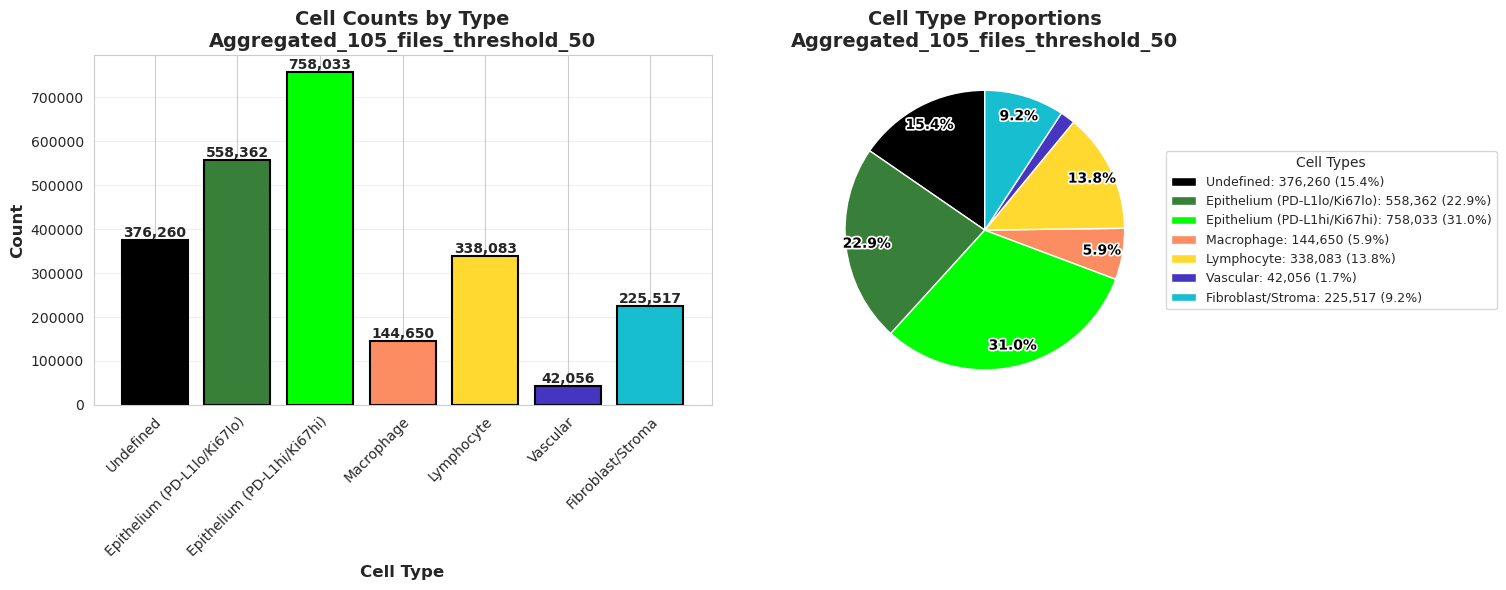

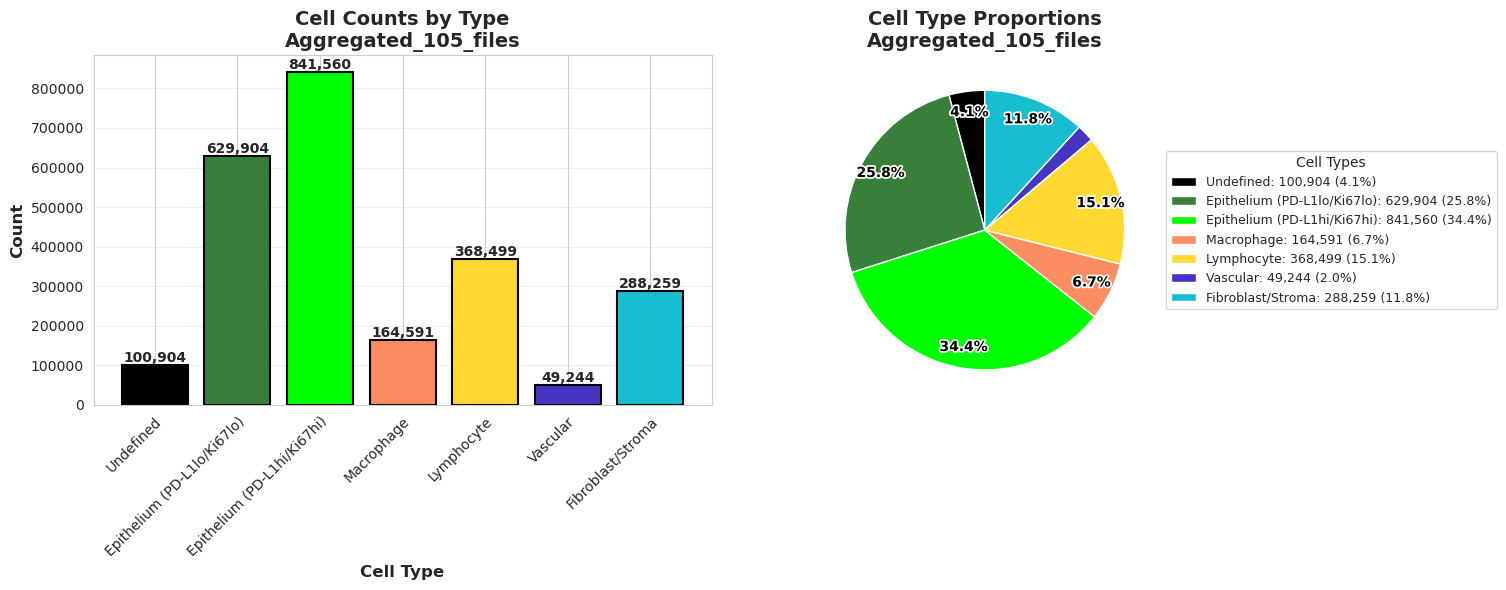

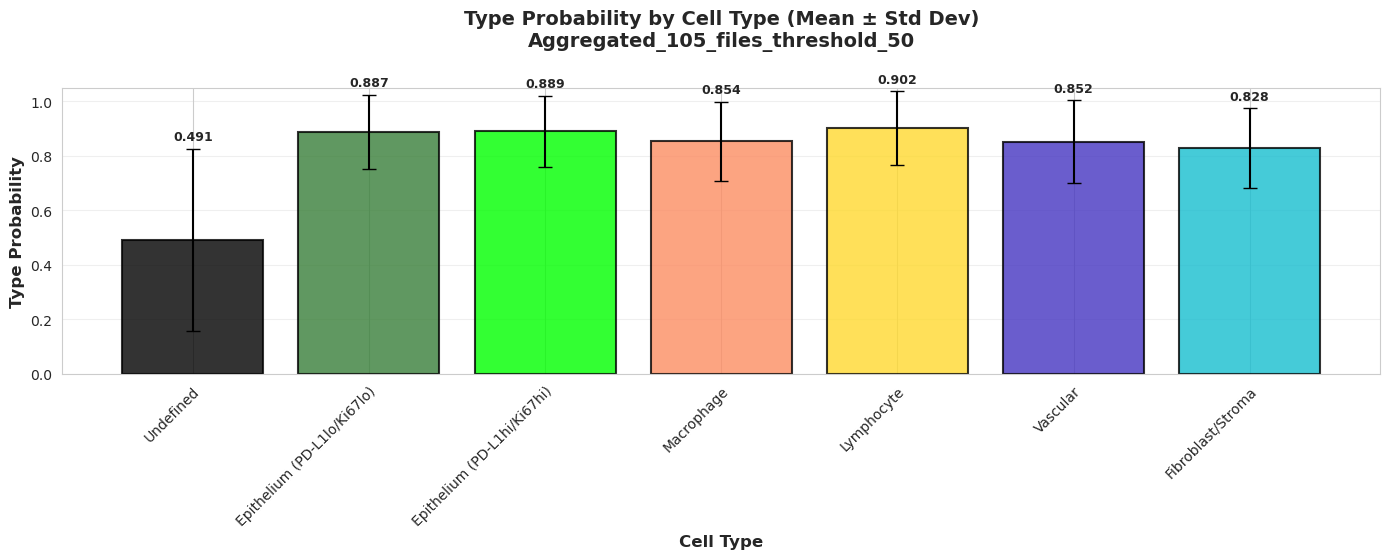

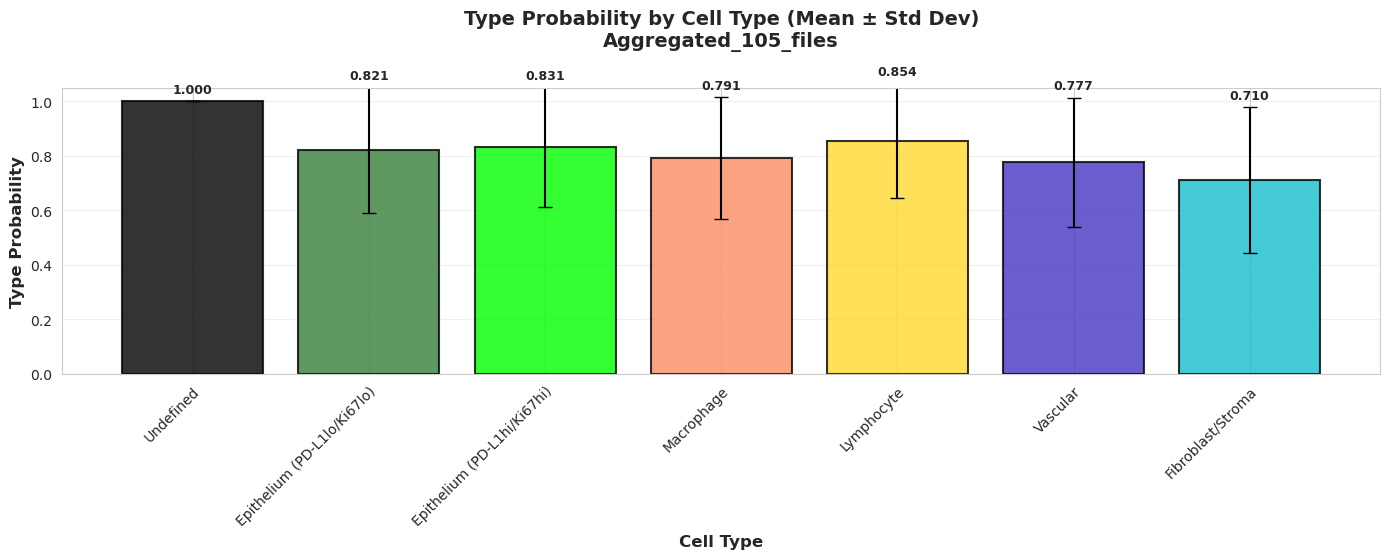


Automatically Exporting Cell Density by Type to CSV

📁 Exporting aggregated unfiltered density summary...
✅ Cell density summary exported to: cell_density_by_type_unfiltered.csv
✅ Exported 7 cell types to cell_density_by_type_unfiltered.csv

📁 Exporting aggregated filtered density summary...
✅ Cell density summary exported to: cell_density_by_type_filtered_50.csv
✅ Exported 7 cell types to cell_density_by_type_filtered_50.csv

💡 Cell density (cells/tile and cells/mm²) by type has been saved to CSV files.


In [12]:
# ⚠️ UPDATE THIS PATH TO YOUR JSON DIRECTORY
json_directory = "/mnt/j/HandE/results/SOW1885_n=201_AT2 40X/Batch_105/pred/json"

# ⚠️ Set your threshold here (default: 0.5)
BATCH_THRESHOLD = 0.5

print(f"Applying confidence threshold filter: {BATCH_THRESHOLD}\n")
# Get unfiltered results
all_results = analyze_multiple_json_files(json_directory, apply_filter=False)
aggregated_unfiltered = aggregate_results(all_results, is_filtered=False)

# Get filtered results
filtered_results = analyze_multiple_json_files(json_directory, apply_filter=True, threshold=BATCH_THRESHOLD)
aggregated_filtered = aggregate_results(filtered_results, is_filtered=True)

print("\n📊 Generating comparison visualizations...\n")

display_results(aggregated_filtered)
display_results(aggregated_unfiltered)
# Display filtered results
plot_cell_type_distribution(aggregated_filtered)
plot_cell_type_distribution(aggregated_unfiltered)

# Create comparison visualizations
plot_type_probability_distribution(aggregated_filtered)
plot_type_probability_distribution(aggregated_unfiltered)

# Automatically export density CSV files
print("\n" + "="*80)
print("Automatically Exporting Cell Density by Type to CSV")
print("="*80)

# Export aggregated unfiltered density
if 'aggregated_unfiltered' in locals():
    print("\n📁 Exporting aggregated unfiltered density summary...")
    df_unfiltered_density = export_density_summary_to_csv(
        aggregated_unfiltered,
        output_path="cell_density_by_type_unfiltered.csv",
        is_filtered=False
    )
    print(f"✅ Exported {len(df_unfiltered_density)} cell types to cell_density_by_type_unfiltered.csv")

# Export aggregated filtered density
if 'aggregated_filtered' in locals():
    print("\n📁 Exporting aggregated filtered density summary...")
    threshold_value = aggregated_filtered.get('threshold', 'N/A')
    threshold_str = str(int(threshold_value * 100)) if isinstance(threshold_value, float) else str(threshold_value)
    df_filtered_density = export_density_summary_to_csv(
        aggregated_filtered,
        output_path=f"cell_density_by_type_filtered_{threshold_str}.csv",
        is_filtered=True
    )
    print(f"✅ Exported {len(df_filtered_density)} cell types to cell_density_by_type_filtered_{threshold_str}.csv")

print("\n💡 Cell density (cells/tile and cells/mm²) by type has been saved to CSV files.")


### Save Aggregated to `.csv`

In [13]:
# Export aggregated results to CSV
# Note: TILE_AREA_MM2 is defined in Cell 4, using global configuration here
print("="*80)
print("Exporting Aggregated Batch Results to CSV")
print("="*80)

if 'aggregated_unfiltered' in locals() and 'aggregated_filtered' in locals():
    # Export aggregated unfiltered results
    print("\n📁 Exporting aggregated unfiltered results...")
    df_aggregated_unfiltered = export_results_to_csv(
        aggregated_unfiltered,
        output_path="batch_aggregated_unfiltered.csv",
        is_filtered=False
    )
    
    # Export aggregated filtered results
    threshold_value = aggregated_filtered.get('threshold', 'N/A')
    threshold_str = str(int(threshold_value * 100)) if isinstance(threshold_value, float) else str(threshold_value)
    filtered_output_path = f"batch_aggregated_filtered_{threshold_str}.csv"
    
    print("\n📁 Exporting aggregated filtered results...")
    df_aggregated_filtered = export_results_to_csv(
        aggregated_filtered,
        output_path=filtered_output_path,
        is_filtered=True
    )
    
    # Display both DataFrames
    print("\n" + "─"*80)
    print("Aggregated Unfiltered Results Preview:")
    print("─"*80)
    display(df_aggregated_unfiltered)
    
    print("\n" + "─"*80)
    print(f"Aggregated Filtered Results Preview (Threshold: {threshold_value}):")
    print("─"*80)
    display(df_aggregated_filtered)
    
    # Calculate additional metrics
    num_files = aggregated_filtered.get('num_files', 0)
    num_tiles = aggregated_filtered.get('num_tiles', num_files)
    total_cells_filtered = aggregated_filtered.get('total_cells', 0)
    tile_area_mm2 = aggregated_filtered.get('tile_area_mm2', TILE_AREA_MM2)
    
    # Calculate average number of cells per tile
    cells_per_tile = total_cells_filtered / num_tiles if num_tiles > 0 else 0
    
    # Calculate average cell density (cells per mm^2)
    total_area_mm2 = num_tiles * tile_area_mm2
    avg_cell_density = total_cells_filtered / total_area_mm2 if total_area_mm2 > 0 else 0
    
    # Summary
    print("\n" + "="*80)
    print("Export Summary:")
    print("="*80)
    print(f"✅ Aggregated unfiltered: batch_aggregated_unfiltered.csv ({len(df_aggregated_unfiltered)} rows)")
    print(f"✅ Aggregated filtered:   {filtered_output_path} ({len(df_aggregated_filtered)} rows)")
    print(f"📊 Total files processed: {num_files}")
    print(f"📊 Total tiles: {num_tiles}")
    print(f"📊 Tile area: {tile_area_mm2} mm^2 per tile")
    print(f"📊 Total area: {total_area_mm2:.2f} mm^2")
    print(f"📊 Total cells (unfiltered): {aggregated_unfiltered.get('total_cells', 0):,}")
    print(f"📊 Total cells (filtered): {total_cells_filtered:,}")
    print(f"📊 Total cells reclassified: {aggregated_filtered.get('reclassified_count', 0):,}")
    print(f"📊 Average cells per tile: {cells_per_tile:,.2f}")
    print(f"📊 Average cell density: {avg_cell_density:,.1f} cells/mm^2")
    print("\n💡 Density by cell type is included in the CSV files (Cells_Per_Tile and Cells_Per_mm2 columns)")
    
    # Also export dedicated density CSV files
    print("\n" + "="*80)
    print("Exporting Dedicated Cell Density CSV Files")
    print("="*80)
    
    # Export unfiltered density
    print("\n📁 Exporting cell density by type (unfiltered)...")
    df_density_unfiltered = export_density_summary_to_csv(
        aggregated_unfiltered,
        output_path="cell_density_by_type_unfiltered.csv",
        is_filtered=False
    )
    print(f"✅ Exported to: cell_density_by_type_unfiltered.csv")
    
    # Export filtered density
    print("\n📁 Exporting cell density by type (filtered)...")
    df_density_filtered = export_density_summary_to_csv(
        aggregated_filtered,
        output_path=f"cell_density_by_type_filtered_{threshold_str}.csv",
        is_filtered=True
    )
    print(f"✅ Exported to: cell_density_by_type_filtered_{threshold_str}.csv")
    
    print("\n💡 Cell density (cells/tile and cells/mm²) by type has been saved to CSV files.")
    print("💡 Files: cell_density_by_type_unfiltered.csv and cell_density_by_type_filtered_{threshold_str}.csv")
    
else:
    print("⚠️ No aggregated results available. Please run Step 8 first.")

Exporting Aggregated Batch Results to CSV

📁 Exporting aggregated unfiltered results...
✅ Results exported to: batch_aggregated_unfiltered.csv

📁 Exporting aggregated filtered results...
✅ Results exported to: batch_aggregated_filtered_50.csv

────────────────────────────────────────────────────────────────────────────────
Aggregated Unfiltered Results Preview:
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Count,Proportion,Percentage,Cells_Per_Tile,Cells_Per_mm2,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std
0,Aggregated_105_files,0,Undefined,100904,0.041304,4.130397,960.990476,240.247619,1.000000,1.000000,1.000000,1.0,1.490116e-08
1,Aggregated_105_files,1,Epithelium (PD-L1lo/Ki67lo),629904,0.257844,25.784448,5999.085714,1499.771429,0.000694,0.820959,0.820959,1.0,2.312032e-01
2,Aggregated_105_files,2,Epithelium (PD-L1hi/Ki67hi),841560,0.344484,34.448360,8014.857143,2003.714286,0.000886,0.831151,0.831151,1.0,2.201030e-01
3,Aggregated_105_files,3,Macrophage,164591,0.067374,6.737357,1567.533333,391.883333,0.000995,0.790683,0.790683,1.0,2.237511e-01
4,Aggregated_105_files,4,Lymphocyte,368499,0.150841,15.084113,3509.514286,877.378571,0.001445,0.853783,0.853783,1.0,2.100182e-01
5,Aggregated_105_files,5,Vascular,49244,0.020158,2.015751,468.990476,117.247619,0.001520,0.776761,0.776761,1.0,2.365989e-01
6,Aggregated_105_files,6,Fibroblast/Stroma,288259,0.117996,11.799574,2745.323810,686.330952,0.001005,0.710139,0.710139,1.0,2.684909e-01



────────────────────────────────────────────────────────────────────────────────
Aggregated Filtered Results Preview (Threshold: 0.5):
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Original_Count,Count,Count_Change,Proportion,Percentage,Cells_Per_Tile,Cells_Per_mm2,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std,Threshold
0,Aggregated_105_files_threshold_50,0,Undefined,100904,376260,275356,0.154018,15.401801,3583.428571,895.857143,0.000694,0.491132,0.491132,1.0,0.334515,0.5
1,Aggregated_105_files_threshold_50,1,Epithelium (PD-L1lo/Ki67lo),629904,558362,-71542,0.228560,22.855952,5317.733333,1329.433333,0.500400,0.887292,0.887292,1.0,0.136536,0.5
2,Aggregated_105_files_threshold_50,2,Epithelium (PD-L1hi/Ki67hi),841560,758033,-83527,0.310293,31.029271,7219.361905,1804.840476,0.500308,0.889192,0.889192,1.0,0.131542,0.5
3,Aggregated_105_files_threshold_50,3,Macrophage,164591,144650,-19941,0.059211,5.921093,1377.619048,344.404762,0.500545,0.854041,0.854041,1.0,0.144654,0.5
4,Aggregated_105_files_threshold_50,4,Lymphocyte,368499,338083,-30416,0.138391,13.839067,3219.838095,804.959524,0.500515,0.901559,0.901559,1.0,0.135523,0.5
5,Aggregated_105_files_threshold_50,5,Vascular,49244,42056,-7188,0.017215,1.721517,400.533333,100.133333,0.500507,0.851876,0.851876,1.0,0.153044,0.5
6,Aggregated_105_files_threshold_50,6,Fibroblast/Stroma,288259,225517,-62742,0.092313,9.231298,2147.780952,536.945238,0.500477,0.828227,0.828227,1.0,0.145931,0.5



Export Summary:
✅ Aggregated unfiltered: batch_aggregated_unfiltered.csv (7 rows)
✅ Aggregated filtered:   batch_aggregated_filtered_50.csv (7 rows)
📊 Total files processed: 105
📊 Total tiles: 105
📊 Tile area: 4.0 mm^2 per tile
📊 Total area: 420.00 mm^2
📊 Total cells (unfiltered): 2,442,961
📊 Total cells (filtered): 2,442,961
📊 Total cells reclassified: 275,356
📊 Average cells per tile: 23,266.30
📊 Average cell density: 5,816.6 cells/mm^2

💡 Density by cell type is included in the CSV files (Cells_Per_Tile and Cells_Per_mm2 columns)

Exporting Dedicated Cell Density CSV Files

📁 Exporting cell density by type (unfiltered)...
✅ Cell density summary exported to: cell_density_by_type_unfiltered.csv
✅ Exported to: cell_density_by_type_unfiltered.csv

📁 Exporting cell density by type (filtered)...
✅ Cell density summary exported to: cell_density_by_type_filtered_50.csv
✅ Exported to: cell_density_by_type_filtered_50.csv

💡 Cell density (cells/tile and cells/mm²) by type has been saved to C

## Step 9: Export Cell Density Summary by Type

Export cell density metrics (cells/tile and cells/mm^2) by cell type to a dedicated CSV file.


In [14]:
# Note: This function is already defined in Cell 17, but defined here again for reference
# If you've run Cell 17, this definition will overwrite the previous one (same function)
def export_density_summary_to_csv(results, output_path="cell_density_summary.csv", is_filtered=False):
    """
    Export cell density metrics (cells/tile and cells/mm^2) by cell type to CSV.
    
    Args:
        results (dict): Results dictionary from analyze_single_json() or aggregate_results()
        output_path (str): Output CSV file path
        is_filtered (bool): Whether results are filtered (adds threshold info)
    
    Returns:
        pd.DataFrame: DataFrame containing density data
    """
    # Prepare DataFrame data
    data_rows = []
    
    for cell_type in sorted(results['cell_counts'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}")
        count = results['cell_counts'][cell_type]
        
        # Get density information
        density_per_tile = results.get('cell_density_per_tile', {}).get(cell_type, 0)
        density_per_mm2 = results.get('cell_density_per_mm2', {}).get(cell_type, 0)
        
        row_data = {
            'Filename': results['filename'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': type_name,
            'Count': count,
            'Cells_Per_Tile': density_per_tile,
            'Cells_Per_mm2': density_per_mm2
        }
        
        # Add tile area info
        row_data['Tile_Area_mm2'] = results.get('tile_area_mm2', TILE_AREA_MM2)
        
        # Add number of tiles if available
        if 'num_tiles' in results:
            row_data['Num_Tiles'] = results['num_tiles']
        
        # Add threshold info for filtered results
        if is_filtered and 'threshold' in results:
            row_data['Threshold'] = results.get('threshold', 'N/A')
        
        data_rows.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Set column order
    base_columns = ['Filename', 'Cell_Type_ID', 'Cell_Type_Name', 'Count', 
                   'Cells_Per_Tile', 'Cells_Per_mm2', 'Tile_Area_mm2']
    
    if 'num_tiles' in results:
        base_columns.insert(-1, 'Num_Tiles')
    
    if is_filtered and 'threshold' in results:
        base_columns.append('Threshold')
    
    df = df[base_columns]
    
    # Export to CSV
    df.to_csv(output_path, index=False)
    print(f"✅ Cell density summary exported to: {output_path}")
    
    return df

print("✅ Function defined: export_density_summary_to_csv()")


✅ Function defined: export_density_summary_to_csv()


In [15]:
# Export density summaries for both single file and batch results
print("="*80)
print("Exporting Cell Density Summary by Type")
print("="*80)

# Export single file results if available
if 'results' in locals():
    print("\n📁 Exporting single file density summary...")
    df_single_density = export_density_summary_to_csv(
        results,
        output_path="cell_density_summary_single_file.csv",
        is_filtered=False
    )
    display(df_single_density)

# Export filtered single file results if available
# Check if filtered_results exists and is a dictionary (single file), not a list (batch results)
if 'filtered_results' in locals() and isinstance(filtered_results, dict):
    print("\n📁 Exporting filtered single file density summary...")
    threshold_value = filtered_results.get('threshold', 'N/A')
    threshold_str = str(int(threshold_value * 100)) if isinstance(threshold_value, float) else str(threshold_value)
    df_filtered_single_density = export_density_summary_to_csv(
        filtered_results,
        output_path=f"cell_density_summary_single_file_filtered_{threshold_str}.csv",
        is_filtered=True
    )
    display(df_filtered_single_density)

# Export aggregated batch results if available
if 'aggregated_unfiltered' in locals():
    print("\n📁 Exporting aggregated batch density summary (unfiltered)...")
    df_aggregated_density = export_density_summary_to_csv(
        aggregated_unfiltered,
        output_path="cell_density_summary_batch_aggregated.csv",
        is_filtered=False
    )
    display(df_aggregated_density)

if 'aggregated_filtered' in locals():
    print("\n📁 Exporting aggregated batch density summary (filtered)...")
    threshold_value = aggregated_filtered.get('threshold', 'N/A')
    threshold_str = str(int(threshold_value * 100)) if isinstance(threshold_value, float) else str(threshold_value)
    df_aggregated_filtered_density = export_density_summary_to_csv(
        aggregated_filtered,
        output_path=f"cell_density_summary_batch_aggregated_filtered_{threshold_str}.csv",
        is_filtered=True
    )
    display(df_aggregated_filtered_density)

print("\n" + "="*80)
print("Density Summary Export Complete")
print("="*80)
print("💡 All density metrics (cells/tile and cells/mm^2) by cell type have been saved to CSV files.")
print("💡 Density columns are also included in the main analysis CSV files.")


Exporting Cell Density Summary by Type

📁 Exporting single file density summary...
✅ Cell density summary exported to: cell_density_summary_single_file.csv


,Filename,Cell_Type_ID,Cell_Type_Name,Count,Cells_Per_Tile,Cells_Per_mm2,Num_Tiles,Tile_Area_mm2
0,tile_39520_7904.json,0,Undefined,49,49.0,12.25,1,4.0
1,tile_39520_7904.json,1,Epithelium (PD-L1lo/Ki67lo),191,191.0,47.75,1,4.0
2,tile_39520_7904.json,2,Epithelium (PD-L1hi/Ki67hi),217,217.0,54.25,1,4.0
3,tile_39520_7904.json,3,Macrophage,228,228.0,57.00,1,4.0
4,tile_39520_7904.json,4,Lymphocyte,1541,1541.0,385.25,1,4.0
5,tile_39520_7904.json,5,Vascular,10,10.0,2.50,1,4.0
6,tile_39520_7904.json,6,Fibroblast/Stroma,267,267.0,66.75,1,4.0



📁 Exporting aggregated batch density summary (unfiltered)...
✅ Cell density summary exported to: cell_density_summary_batch_aggregated.csv


,Filename,Cell_Type_ID,Cell_Type_Name,Count,Cells_Per_Tile,Cells_Per_mm2,Num_Tiles,Tile_Area_mm2
0,Aggregated_105_files,0,Undefined,100904,960.990476,240.247619,105,4.0
1,Aggregated_105_files,1,Epithelium (PD-L1lo/Ki67lo),629904,5999.085714,1499.771429,105,4.0
2,Aggregated_105_files,2,Epithelium (PD-L1hi/Ki67hi),841560,8014.857143,2003.714286,105,4.0
3,Aggregated_105_files,3,Macrophage,164591,1567.533333,391.883333,105,4.0
4,Aggregated_105_files,4,Lymphocyte,368499,3509.514286,877.378571,105,4.0
5,Aggregated_105_files,5,Vascular,49244,468.990476,117.247619,105,4.0
6,Aggregated_105_files,6,Fibroblast/Stroma,288259,2745.323810,686.330952,105,4.0



📁 Exporting aggregated batch density summary (filtered)...
✅ Cell density summary exported to: cell_density_summary_batch_aggregated_filtered_50.csv


,Filename,Cell_Type_ID,Cell_Type_Name,Count,Cells_Per_Tile,Cells_Per_mm2,Num_Tiles,Tile_Area_mm2,Threshold
0,Aggregated_105_files_threshold_50,0,Undefined,376260,3583.428571,895.857143,105,4.0,0.5
1,Aggregated_105_files_threshold_50,1,Epithelium (PD-L1lo/Ki67lo),558362,5317.733333,1329.433333,105,4.0,0.5
2,Aggregated_105_files_threshold_50,2,Epithelium (PD-L1hi/Ki67hi),758033,7219.361905,1804.840476,105,4.0,0.5
3,Aggregated_105_files_threshold_50,3,Macrophage,144650,1377.619048,344.404762,105,4.0,0.5
4,Aggregated_105_files_threshold_50,4,Lymphocyte,338083,3219.838095,804.959524,105,4.0,0.5
5,Aggregated_105_files_threshold_50,5,Vascular,42056,400.533333,100.133333,105,4.0,0.5
6,Aggregated_105_files_threshold_50,6,Fibroblast/Stroma,225517,2147.780952,536.945238,105,4.0,0.5



Density Summary Export Complete
💡 All density metrics (cells/tile and cells/mm^2) by cell type have been saved to CSV files.
💡 Density columns are also included in the main analysis CSV files.


## Summary

This notebook provides:
1. ✅ Single JSON file analysis
2. ✅ Cell type counts and proportions
3. ✅ Cell density calculation (cells/tile and cells/mm²) by type
4. ✅ Type probability statistics (min, median, mean, max)
5. ✅ Visualizations (bar charts, pie charts)
6. ✅ CSV export functionality (including density by type)
7. ✅ Batch processing for all JSON files
8. ✅ Automatic density CSV export (cells/tile and cells/mm² by cell type)

**Cell Density Features:**
- Calculates cell density per tile and per mm² for each cell type
- Exports density metrics to dedicated CSV files
- Includes density information in all analysis CSV exports
- Displays density in results summary

**Next Steps:**
- Use these counts for spatial analysis
- Compare distributions across different tissue regions
- Analyze cell density patterns by type
- Correlate with clinical outcomes

---